# Regressions linéaires
*Temps d'éxécution : environ 6-7 minutes*.


Dans cette section on essaie de voir si l'on peut, et dans quelle mesure, il est possible de prédire le nombre de validations dans les stations de RER avec les données à notre disposition.

## Importation et préparation des données

In [1]:
import pandas as pd
from _jointure_validations_stations import df_jointure_validations_stations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
data=df_jointure_validations_stations()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


On a vue que le titre de transport importe peu : on aggrège donc les données en fonction du `JOUR`et de `nom_long`.

In [12]:
aggregation_functions = {'NB_VALD': 'sum'}

# Liste avec les colonnes de l'INSEE
Insee_columns = [
    'ind', 'men', 'men_pauv', 'men_1ind', 'men_5ind', 'men_prop', 'men_fmp', 
    'ind_snv', 'men_surf', 'men_coll', 'men_mais', 'log_av45', 'log_45_70', 
    'log_70_90', 'log_ap90', 'log_inc', 'log_soc', 'ind_0_3', 'ind_4_5', 
    'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39', 'ind_40_54', 
    'ind_55_64', 'ind_65_79', 'ind_80p', 'lda', 'res_com'
]

for column in Insee_columns:
    aggregation_functions[column] = 'first'

data_jour_stations = data.groupby(['JOUR','nom_long']).agg(aggregation_functions)
data_jour_stations=data_jour_stations.reset_index()

Création de dummies en fonction de la ligne de RER.

In [22]:
data_jour_stations['RER A'] = data_jour_stations['res_com'].apply(lambda x: 1 if x == 'RER A' else 0)
data_jour_stations['RER B'] = data_jour_stations['res_com'].apply(lambda x: 1 if x == 'RER B' else 0)
data_jour_stations['RER C'] = data_jour_stations['res_com'].apply(lambda x: 1 if x == 'RER C' else 0)
data_jour_stations['RER D'] = data_jour_stations['res_com'].apply(lambda x: 1 if x == 'RER D' else 0)
data_jour_stations['RER E'] = data_jour_stations['res_com'].apply(lambda x: 1 if x == 'RER E' else 0)

In [26]:
# Liste des valeurs pour lesquelles RER COR sera 1
rer_cor_list = ['RER D, RER A', 'RER C, RER D', 'RER E, RER B, RER D', 'RER A, RER E']

# Création de la colonne RER COR
data_jour_stations['RER COR'] = data_jour_stations['res_com'].apply(lambda x: 1 if x in rer_cor_list else 0)

In [27]:
data_jour_stations[data_jour_stations['RER COR']==1]

,JOUR,nom_long,NB_VALD,ind,men,men_pauv,men_1ind,men_5ind,men_prop,men_fmp,...,ind_65_79,ind_80p,lda,res_com,RER A,RER B,RER C,RER D,RER E,RER COR
40,2023-01-01,Gare de Lyon,50846,7920.5,3525.0,450.0,1514.0,301.0,797.0,436.0,...,864.0,266.0,73626,"RER D, RER A",0,0,0,0,0,1
52,2023-01-01,Juvisy,4884,5816.0,2855.9,297.1,1240.0,120.0,1474.0,279.0,...,557.0,283.9,62737,"RER C, RER D",0,0,0,0,0,1
73,2023-01-01,Magenta,33867,27806.0,13477.0,2735.0,6647.0,903.0,4607.0,1333.0,...,2783.0,803.0,71410,"RER E, RER B, RER D",0,0,0,0,0,1
125,2023-01-01,Val de Fontenay,3117,6707.0,2526.0,444.0,722.1,320.0,713.1,458.0,...,779.0,238.0,71718,"RER A, RER E",0,0,0,0,0,1
186,2023-01-02,Gare de Lyon,100659,7920.5,3525.0,450.0,1514.0,301.0,797.0,436.0,...,864.0,266.0,73626,"RER D, RER A",0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26433,2023-06-29,Val de Fontenay,26118,6707.0,2526.0,444.0,722.1,320.0,713.1,458.0,...,779.0,238.0,71718,"RER A, RER E",0,0,0,0,0,1
26494,2023-06-30,Gare de Lyon,114605,7920.5,3525.0,450.0,1514.0,301.0,797.0,436.0,...,864.0,266.0,73626,"RER D, RER A",0,0,0,0,0,1
26506,2023-06-30,Juvisy,21100,5816.0,2855.9,297.1,1240.0,120.0,1474.0,279.0,...,557.0,283.9,62737,"RER C, RER D",0,0,0,0,0,1
26528,2023-06-30,Magenta,70337,27806.0,13477.0,2735.0,6647.0,903.0,4607.0,1333.0,...,2783.0,803.0,71410,"RER E, RER B, RER D",0,0,0,0,0,1


In [28]:
data_jour_stations=data_jour_stations[data_jour_stations['RER COR']==0]

In [29]:
data_jour_stations.shape

(25876, 38)

On commence par définir notre variable d'intêret : on essayera de comprendre et prédire le nombre de validations `NB_VALD`. Ensuite on classe nos variables selon qu'elles soient catégorielles ou numériques, et enfin, on les regroupe toutes dans les *features*. On définit également une *seed* pour favoriser la réplicabilité de nos résultats.

In [30]:
TARGET_VARIABLE="NB_VALD"
CATEGORICAL=["RER A", "RER B", "RER C", "RER D"]
NUMERICAL = [x for x in data_jour_stations.columns if x not in ['index', 'level_0', "RER A", "RER B", "RER C", "RER D", "NB_VALD", "nom_long", "lda", "res_com"]]
FEATURES = NUMERICAL + CATEGORICAL
SEED=12

In [31]:
FEATURES

['JOUR',
 'ind',
 'men',
 'men_pauv',
 'men_1ind',
 'men_5ind',
 'men_prop',
 'men_fmp',
 'ind_snv',
 'men_surf',
 'men_coll',
 'men_mais',
 'log_av45',
 'log_45_70',
 'log_70_90',
 'log_ap90',
 'log_inc',
 'log_soc',
 'ind_0_3',
 'ind_4_5',
 'ind_6_10',
 'ind_11_17',
 'ind_18_24',
 'ind_25_39',
 'ind_40_54',
 'ind_55_64',
 'ind_65_79',
 'ind_80p',
 'RER E',
 'RER COR',
 'RER A',
 'RER B',
 'RER C',
 'RER D']

On divise notre jeu de données en deux parties : la première servira à entrainer le modèle tandis que la deuxième nous permettra de tester son efficacité.

In [32]:
X = data_jour_stations[FEATURES]
y = data_jour_stations[TARGET_VARIABLE]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Première regression
### Préparation des varaibles et de la regression
On commence par sélectionner quelques variables qui se sont montrées pertinantes dans les statistiques descriptives pour faire une première regression.

On sélectionne ensuite les données correspondantes aux variables choisies dans l'échantillon d'entrainement et de test. Les données ayant été déjà traitées nous n'avons pas de manipulation supplémentaire à faire ici. Il nous reste simplement à standardiser nos variables.

In [33]:
CATEGORICAL_REGRESSION = ["RER A", "RER B", "RER C", "RER D"]

NUMERICAL_REGRESSION = ["men","men_1ind", "men_pauv", "men_coll",
                        "log_av45", "ind_25_39"]

FEATURES_REGRESSION = NUMERICAL_REGRESSION + CATEGORICAL_REGRESSION

X_train_regression = X_train[FEATURES_REGRESSION]
X_test_regression = X_test[FEATURES_REGRESSION]

On standardise nos données à l'aide de *StandardScaler* puis on modifie l'affichage pour avoir des noms de colonnes lisibles.

In [34]:
preprocessor_regression = ColumnTransformer(
    transformers=[
        ("stand", StandardScaler(), NUMERICAL_REGRESSION),
        ("cat",  StandardScaler(), CATEGORICAL_REGRESSION)
    ]
)

In [35]:
preprocessor_regression.fit(X_train_regression)
original_feature_names = [re.sub(r'^.*__', '', item) for item in preprocessor_regression.get_feature_names_out()]
original_feature_names

['men',
 'men_1ind',
 'men_pauv',
 'men_coll',
 'log_av45',
 'ind_25_39',
 'RER A',
 'RER B',
 'RER C',
 'RER D']

On prépare maintenant un Pipeline pour faire nos régressions.

In [36]:
pipe_lr = Pipeline([
    ('preprocessor', preprocessor_regression), # 1ère étape réaliser le preprocessing
    ('regression', LinearRegression()) # 2ème étape estime notre régression linéaire
])

On peut donc réaliser maintenant notre régression et évaluer la qualité de la prédiction avec le reste de notre jeu de données.
### Réalisation de la regression et évaluation du modèle

In [37]:
#modèle de regression
lr = pipe_lr.fit(X_train_regression, y_train)
coefficients = pipe_lr.named_steps['regression'].coef_
column_names = X_train_regression.columns

#prediction
y_pred = lr.predict(X_test_regression)

#calcul des indicateurs
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
coef_df = pd.DataFrame({
    'Feature': column_names,
    'Coefficient': coefficients
})

Le RMSE sur le jeu de test est : 4470.0112
Le R2 sur le jeu de test est : 0.4863


Afin d'interpréter ces données nous avons besoin de statistiques sur le nombres validations (`NB_VALD`)

In [38]:
print(f"La variance de NB_VALD de jeu de test est : {round(y_test.var(), 4)}")
print(f"La moyenne de NB_VALD de jeu de test est : {round(y_test.mean(), 4)}")
print(f"L'écart interquartile de NB_VALD de jeu de test est : {round(y_test.quantile(0.75) - y_test.quantile(0.25), 4)}")

La variance de NB_VALD de jeu de test est : 38907495.0464
La moyenne de NB_VALD de jeu de test est : 5319.1233
L'écart interquartile de NB_VALD de jeu de test est : 6722.25


Le R² est plutôt bon, particulièrement au vue de la variance de `NB_VALD`. 

Le RMSE est environ 1,66 fois plus grand que la moyenne : cela veut donc dire que les erreurs sont assez significatives puisque la valeur prédite varie en moyenne de plus ou moins 13 000 validations, alors que le nombre de validations moyen est de presque 8 000. Cela est assez mauvais. Néanmoins, si l'on compare le RMSE avec l'écart interquartile et la variance du nombres de validations on se rend compte que le modèle est assez proche des données en termes de dispersion. Cela indique que la très forte variabilité des données n'est pas bien expliquée par notre modèle (mais qu'il ne donne pas une vision trop "simpliste" qui pourrait donner plus de variabilités).

Pour finir, on représente les données et on observe les coefficients.

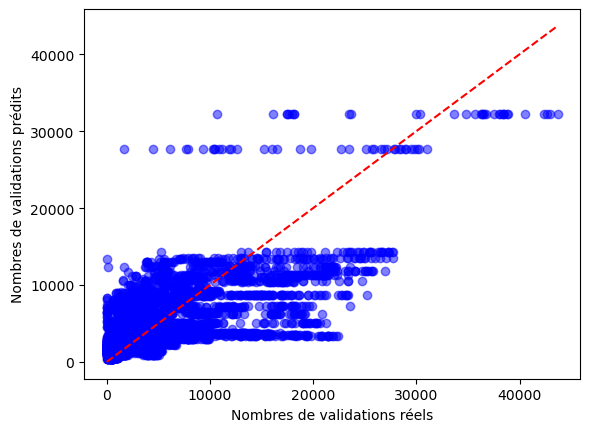

In [39]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

plt.xlabel('Nombres de validations réels')
plt.ylabel('Nombres de validations prédits')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

In [40]:
coef_df

,Feature,Coefficient
0,men,-8528.279411
1,men_1ind,5565.617001
2,men_pauv,2036.121318
3,men_coll,1028.111939
4,log_av45,176.400668
5,ind_25_39,3215.013043
6,RER A,2067.008162
7,RER B,486.843444
8,RER C,-757.750728
9,RER D,-365.888688


In [41]:
pipe_lr.named_steps['regression'].intercept_

5209.456618357489

Le modèle est particulièrement mauvais pour des valeurs de de `NB_VALD` très élevés. Les coefficients ne donnent pas une interprétation très évidente. Il y a, avec ce modèle, une corrélation négative entre le nombre de validations et le nombre de ménages présent dans le carreau Insee de 1km de la gare. Cela vient surement des autres variables prises en compte dans le modèle qui contiennent d'autres informations socio-démographiques.

## Regression Lasso
On réalise une regression Lasso sur l'ensemble des variables que nous avons à notre disposition afin de sélectionner les meilleures. Pour réduire la variabilité, on travaille avec des données aggrégées par stations (on enlève les différents jours et l'on cherche à prédure la fréquentation globale d'une station).
### Préparation de la regression

In [43]:
data_stations = data.groupby('nom_long').agg(aggregation_functions)
data_stations['RER A'] = data_stations['res_com'].apply(lambda x: 1 if x == 'RER A' else 0)
data_stations['RER B'] = data_stations['res_com'].apply(lambda x: 1 if x == 'RER B' else 0)
data_stations['RER C'] = data_stations['res_com'].apply(lambda x: 1 if x == 'RER C' else 0)
data_stations['RER D'] = data_stations['res_com'].apply(lambda x: 1 if x == 'RER D' else 0)
data_stations['RER E'] = data_stations['res_com'].apply(lambda x: 1 if x == 'RER E' else 0)

In [45]:
data_stations['res_com'].unique()

array(['RER C', 'RER A', 'RER B', 'RER D', 'RER E', 'RER D, RER A',
       'RER C, RER D', 'RER E, RER B, RER D', 'RER A, RER E'],
      dtype=object)

In [46]:
# Liste des valeurs pour lesquelles RER COR sera 1
rer_cor_list = ['RER D, RER A','RER C, RER D', 'RER E, RER B, RER D', 'RER A, RER E']

# Création de la colonne RER COR
data_stations['RER COR'] = data_stations['res_com'].apply(lambda x: 1 if x in rer_cor_list else 0)

In [47]:
data_stations=data_stations[data_stations['RER COR']==0]

In [48]:
X_train_regression = X_train[FEATURES]
X_test_regression = X_test[FEATURES]

In [49]:
CATEGORICAL_REGRESSION = ["RER A", "RER B", "RER C", "RER D", "RER E"]

NUMERICAL_REGRESSION = ['men', 'men_pauv', 'men_1ind', 'men_5ind',
                        'men_prop', 'men_fmp', 'ind_snv', 'men_surf', 'men_coll', 
                        'men_mais', 'log_av45', 'log_45_70', 'log_70_90', 'log_ap90', 
                        'log_inc', 'log_soc', 'ind_0_3', 'ind_4_5', 'ind_6_10', 
                        'ind_11_17', 'ind_18_24', 'ind_25_39','ind_40_54', 'ind_55_64', 
                        'ind_65_79', 'ind_80p',]

FEATURES_REGRESSION = NUMERICAL_REGRESSION + CATEGORICAL_REGRESSION

X_train_regression = X_train[FEATURES_REGRESSION]
X_test_regression = X_test[FEATURES_REGRESSION]

preprocessor_regression = ColumnTransformer(
    transformers=[
        ("stand", StandardScaler(), NUMERICAL_REGRESSION),
        ("cat",  StandardScaler(), CATEGORICAL_REGRESSION)
    ]
)

### Choix du paramètre alpha optimal
On cherche maintnenat le paramètre optimal pour notre regression Lasso avec la cross validation.

In [50]:
pipe_lasso_cv = Pipeline([
    ('preprocessor', preprocessor_regression),  # Première étape: réaliser le preprocessing
    ('regression', LassoCV(cv=5, random_state=0))  # Seconde étape: régression Lasso avec sélection d'alpha via CV
])

In [51]:
pipe_lasso_cv.fit(X_train, y_train)

# Accéder au meilleur alpha et au modèle entraîné
best_alpha = pipe_lasso_cv.named_steps['regression'].alpha_
print("Meilleur alpha trouvé:", best_alpha)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83431139.9265747, tolerance: 66133032.99832927
  model = cd_fast.enet_coordinate_descent_gram(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172127571.06625366, tolerance: 66133032.99832927
  model = cd_fast.enet_coordinate_descent_gram(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 244729625.62542725, tolerance: 66133032.99832927
  model = cd_fast.enet_coordinate_descent_gram(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWa

Meilleur alpha trouvé: 3.8143065567894596


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.278e+10, tolerance: 8.187e+07
  model = cd_fast.enet_coordinate_descent(


### Réalisation de la régression et évaluation du modèle 

In [52]:
pipe_lasso = Pipeline([
    ('preprocessor', preprocessor_regression), # 1ère étape réaliser le preprocessing
    ('regression', Lasso(alpha=best_alpha)) # 2ème étape estime notre régression linéaire
])

In [53]:
#modèle de regression
lr = pipe_lasso.fit(X_train_regression, y_train)
coefficients = pipe_lr.named_steps['regression'].coef_
column_names = X_train_regression.columns

#prediction
y_pred = lr.predict(X_test_regression)

#calcul des indicateurs
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")

Le RMSE sur le jeu de test est : 4173.5659
Le R2 sur le jeu de test est : 0.5522


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.278e+10, tolerance: 8.187e+07
  model = cd_fast.enet_coordinate_descent(


In [54]:
coefficients=pipe_lasso.named_steps['regression'].coef_
column_names=X_train_regression.columns
coef_df = pd.DataFrame({
    'Feature': column_names,
    'Coefficient': coefficients
})
coef_df

,Feature,Coefficient
0,men,-0.000000
1,men_pauv,1579.435949
2,men_1ind,-3701.639957
3,men_5ind,-1419.593500
4,men_prop,-392.114984
5,men_fmp,-7245.435794
6,ind_snv,-10858.750760
7,men_surf,0.000000
8,men_coll,14868.082612
9,men_mais,670.608848


In [55]:
pipe_lasso.named_steps['regression'].intercept_

5209.456618357488

Le R² et le RMSE sont meilleurs, mais pas non plus améliorés de manière significative. Néanmoins les prédictions ne sont pas encore très bonnes.

On remarque que le *lasso* n'a forcé qu'une seule variable à 0 : `ind_snv` (somme des revenus winsorisés). Il semble donc que les revenus associés aux résidents les plus proches des stations de *RER* ne joue pas dans la prédiction de la fréquentation avec les autres variables que nous avons à notre disposition. La très forte corrélation entre les variables socio-démographiques de l'Insee explique le fait que le lasso a du mal a choisir tels ou tels variables (et donc à en exclure).

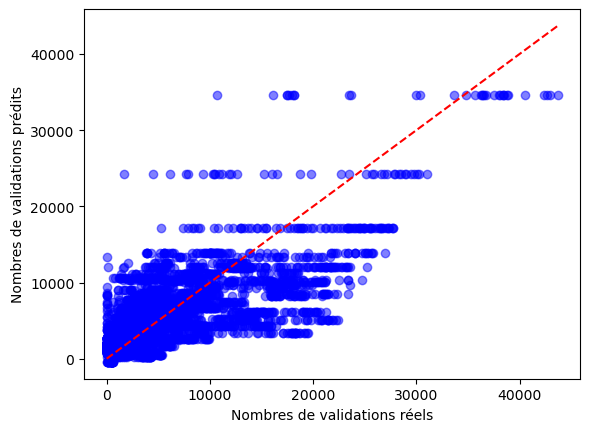

In [56]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

plt.xlabel('Nombres de validations réels')
plt.ylabel('Nombres de validations prédits')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

En observant ce graphique on observe bien que les prédictions ne sont pas très bonnes pour les nombres de validations importants, bien que meilleures que dans le cadre de la première regression.

D'autres méthodes de *machine learning* pourraient peut-être permettre de faire mieux, mais au vu de la complexité des données et des très nombreuses interractifs sur des territoires aussi denses, il est difficile de faire de bonnes prédictions de fréquentation. 

Nous pouvons noter plusieurs limites à notre approches :
* Nous n'utilisons que les données de validations des abonnements ;
* Les données socio-démographiques ne concernent que le carreau de 1km autour de la gare : on peut penser que la sphère d'influence est un peu plus importante dans les stations de *RER*, particulièrement dans les stations éloignées de Paris, tandis que pour les stations dans Paris cela est peut-être déjà bien trop grand ;
* Les données sociodémographiques pourraient être enrichies pour mieux saisir la spécificité des territoires.